In [1]:
filename = '/home/octo/Dropbox'+ '/SPY29Dec.csv'

In [16]:
# loading csv file
def get_csv_pd(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    #spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd
def BA(df):
    df.bidPrice=df.loc[:,'bidPrice'].replace(to_replace=0, method='ffill')
    df.bidSize=df.loc[:,'bidSize'].replace(to_replace=0, method='ffill')
    df.askPrice=df.loc[:,'askPrice'].replace(to_replace=0, method='ffill')
    df.askSize=df.loc[:,'askSize'].replace(to_replace=0, method='ffill')
    df=df.dropna()
    return df
def preprocessing(df):
    df=df.dropna()
    # to exclude 0
    #data=data[data['bidPrice']>240]
    #data=data[data['askPrice']>240]
    df=df[df['bidPrice']>df.bidPrice.mean()-df.bidPrice.std()]
    df=df[df['askPrice']>df.askPrice.mean()-df.askPrice.std()]
    df['mid']=(df.askPrice+df.bidPrice)/2
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['high']=df.askPrice.rolling(60).max()
    df['low']=df.bidPrice.rolling(60).min()
    df=df.dropna()
    return df

In [17]:
import numpy as np
import pandas as pd

In [18]:
data=get_csv_pd(filename)
data=BA(data)
data=preprocessing(data)

In [46]:
len(data)

65365

In [19]:
data.head()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,high,low
2017-12-29 21:14:58.135570,267.820007,54.0,267.809998,14.0,267.815002,267.817963,267.820007,267.799988
2017-12-29 21:14:58.820995,267.820007,54.0,267.809998,19.0,267.815002,267.817383,267.820007,267.799988
2017-12-29 21:15:00.302764,267.820007,54.0,267.809998,23.0,267.815002,267.817017,267.820007,267.799988
2017-12-29 21:15:00.310661,267.820007,49.0,267.809998,23.0,267.815002,267.816803,267.820007,267.799988
2017-12-29 21:15:00.323921,267.820007,49.0,267.809998,28.0,267.815002,267.816345,267.820007,267.799988


In [20]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
from scipy import poly1d
import matplotlib.pyplot as plt

In [48]:
def kalman_ma(data):
    x=data.bidPrice
    y=data.askPrice
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 246,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    data['km']=state_means
    data=data.dropna()
    return data

In [49]:
dataset=kalman_ma(data)

In [50]:
dataset.tail()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,high,low,km
2017-12-31 07:37:42.198573,266.0,59.0,265.98999,5.0,265.994995,265.999207,266.079987,265.98999,265.990639
2017-12-31 07:37:45.649633,266.0,58.0,265.98999,5.0,265.994995,265.999207,266.079987,265.98999,265.990577
2017-12-31 07:37:49.946201,266.0,55.0,265.98999,5.0,265.994995,265.999176,266.079987,265.98999,265.990521
2017-12-31 07:37:52.921372,266.0,55.0,265.98999,1.0,265.994995,265.999817,266.079987,265.98999,265.990471
2017-12-31 07:37:56.170620,266.0,50.0,265.98999,1.0,265.994995,265.999817,266.079987,265.98999,265.990425


In [51]:
len(dataset)

65365

### Momentum

    Hurst exponent helps test whether the time series is:
    (1) A Random Walk (H ~ 0.5)
    (2) Trending (H > 0.5)
    (3) Mean reverting (H < 0.5)
    https://www.quantopian.com/posts/hurst-exponent
    https://www.quantopian.com/posts/neural-network-that-tests-for-mean-reversion-or-momentum-trending

In [52]:
def hurst(data):
  
    tau, lagvec = [], []
    # Step through the different lags
    for lag in range(2,20):  
        # Produce price different with lag
        pp = np.subtract(data[lag:],data[:-lag])
        # Write the different lags into a vector
        lagvec.append(lag)
        # Calculate the variance of the difference
        tau.append(np.sqrt(np.std(pp)))
    # Linear fit to a double-log graph to get power
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)
    # Calculate hurst
    hurst = m[0]*2
    
    return hurst      

In [55]:
H=hurst(dataset.mid.tail(100))

In [56]:
H

0.6543392022599912

https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Quantopian%20Lecture%20Series%3A%20Measuring%20Momentum%22.ipynb

In [57]:
from statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=5).mean()
  if __name__ == '__main__':
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=15).mean()
  from ipykernel import kernelapp as app


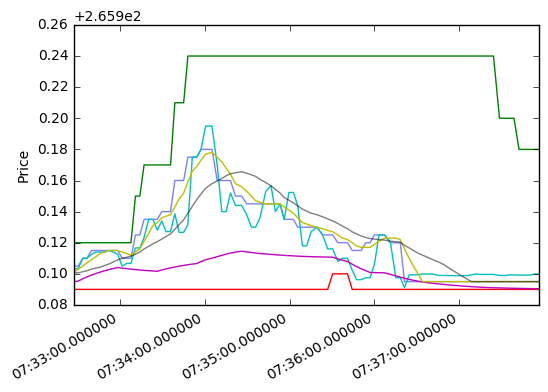

In [63]:
short_mavg = pd.rolling_mean(dataset.mid,5)
long_mavg = pd.rolling_mean(dataset.mid,15)

dataset.mid.tail(100).plot(alpha = 0.5)
dataset.high.tail(100).plot()
dataset.low.tail(100).plot()
dataset.vwap.tail(100).plot()
dataset.km.tail(100).plot()
short_mavg.tail(100).plot()
long_mavg.tail(100).plot(alpha = 0.5)

plt.ylabel('Price')
plt.show()

### Moving Average Crossover Ribbons

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=20).mean()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=40).mean()
/hom

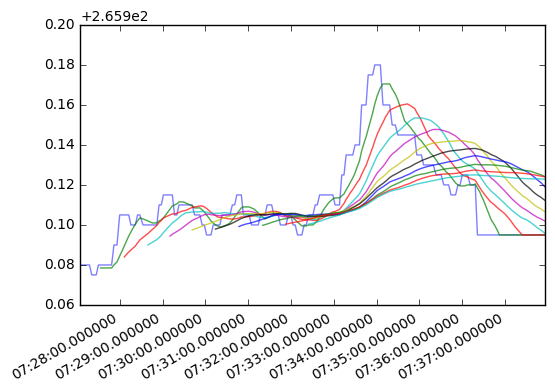

In [70]:
asset=dataset.mid.tail(200)
asset.plot(alpha = 0.5)

rolling_means = {}

for i in np.linspace(10, 100, 10):
    X = pd.rolling_mean(asset,int(i))
    rolling_means[i] = X
    X.plot(alpha = 0.7)
    
rolling_means = pd.DataFrame(rolling_means).dropna()
plt.show()

### Information from the above Ribbon
##### Distance Metric

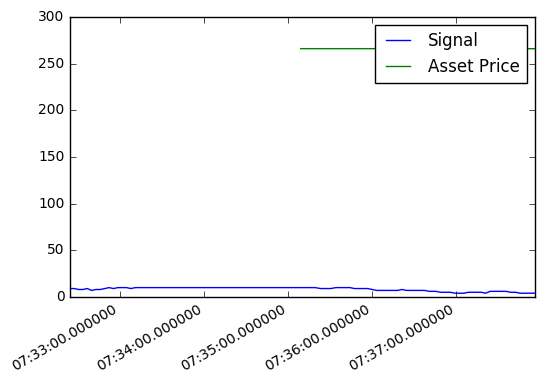

In [78]:
asset=dataset.mid.tail(50)
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    d = distance.hamming(ranking, range(1, 11))
    scores[date] = d
    
# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);
plt.show()

#### correlation metric.

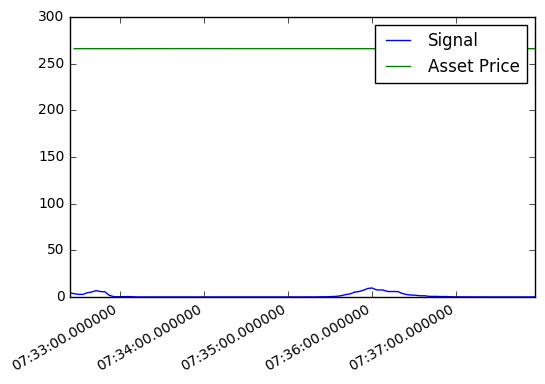

In [81]:
asset=dataset.mid.tail(100)
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    _, d = stats.spearmanr(ranking, range(1, 11))
    scores[date] = d

# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);
plt.show()

#### Measuring Thickness

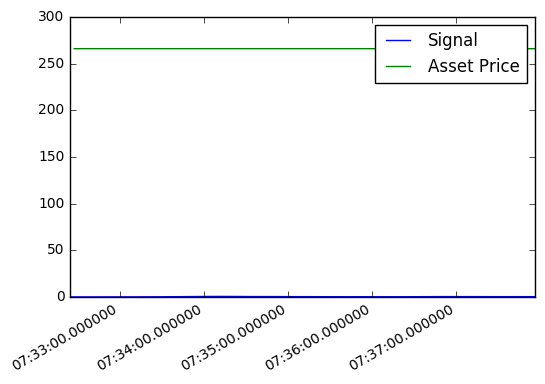

In [87]:
asset=dataset.km.tail(100)
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    d = np.max(mavg_values) - np.min(mavg_values)
    scores[date] = d
    
# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);
plt.show()

#### Momentum From Physics

In [101]:
k = 30
pricing=dataset.mid.tail(1000)
x = np.log(pricing)
v = x.diff()
m = (0.5*(dataset.askSize.tail(1000)+dataset.bidSize.tail(1000)))/((max(dataset.askSize)+max(dataset.bidSize))*0.5)

p0 = pd.rolling_sum(v, k)
p1 = pd.rolling_sum(m*v, k)
p2 = p1/pd.rolling_sum(m, k)
p3 = pd.rolling_mean(v, k)/pd.rolling_std(v, k)

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
/home/oct

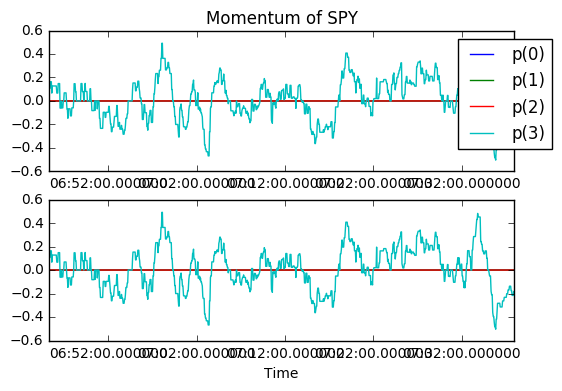

In [102]:
f, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(p0)
ax1.plot(p1)
ax1.plot(p2)
ax1.plot(p3)
ax1.set_title('Momentum of SPY')
ax1.legend(['p(0)', 'p(1)', 'p(2)', 'p(3)'], bbox_to_anchor=(1.1, 1))


ax2.plot(p0)
ax2.plot(p1)
ax2.plot(p2)
ax2.plot(p3)
#ax2.axis([0, 300, -0.005, 0.005])
ax2.set_xlabel('Time');
plt.show()

In [103]:
def get_p(prices, m, d, k):
    """ Returns the dth-degree rolling momentum of data using lookback window length k """
    x = np.log(prices)
    v = x.diff()
    m = np.array(m)
    
    if d == 0:
        return pd.rolling_sum(v, k)
    elif d == 1:
        return pd.rolling_sum(m*v, k)
    elif d == 2:
        return pd.rolling_sum(m*v, k)/pd.rolling_sum(m, k)
    elif d == 3:
        return pd.rolling_mean(v, k)/pd.rolling_std(v, k)
    
def backtest_get_p(prices, m, d):
    """ Returns the dth-degree rolling momentum of data"""
    v = np.diff(np.log(prices))
    m = np.array(m)
    
    if d == 0:
        return np.sum(v)
    elif d == 1:
        return np.sum(m*v)
    elif d == 2:
        return np.sum(m*v)/np.sum(m)
    elif d == 3:
        return np.mean(v)/np.std(v)

In [104]:
k = 30
d=3
prices=dataset.mid.tail(1000)
x = np.log(pricing)
v = x.diff()
m = (0.5*(dataset.askSize.tail(1000)+dataset.bidSize.tail(1000)))/((max(dataset.askSize)+max(dataset.bidSize))*0.5)

p0 = pd.rolling_sum(v, k)
p1 = pd.rolling_sum(m*v, k)
p2 = p1/pd.rolling_sum(m, k)
p3 = pd.rolling_mean(v, k)/pd.rolling_std(v, k)

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).sum()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
/home/oc

#### REF:
    https://www.quantopian.com/posts/some-code-from-ernie-chans-new-book-implemented-in-python